# Import modules and Preporcessing

In [51]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Load images

In [2]:
dataset_root_folder = './flowers'

x_image = []
y_label = []

labels = os.listdir(dataset_root_folder)

for dirname in labels:
	filepath = os.path.join(dataset_root_folder, dirname)
	for file in os.listdir(filepath):
		filename = os.path.join(filepath, file)
		image = cv2.imread(filename)
		# image = cv2.resize(image, (300,300))
		x_image.append(image)
		y_label.append(dirname)
		continue
	continue

### Extract color histogram features

In [88]:
x_hist = []
color = ('b','g','r')

for img in x_image:
    ls = []
    for i,col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ls.append(hist)
    x_hist.append(ls)

### Split dataset into training, validation, and test

In [89]:
seed = 321
x_train_val, x_test, y_train_val, y_test = train_test_split(x_hist, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True, stratify=y_train_val)

In [77]:
x_train.head()

626     [[[1350.0], [454.0], [428.0], [435.0], [497.0]...
3014    [[[10418.0], [2161.0], [2038.0], [1648.0], [14...
3748    [[[0.0], [3.0], [0.0], [1.0], [1.0], [5.0], [5...
441     [[[12931.0], [2848.0], [3019.0], [2917.0], [29...
2226    [[[12172.0], [3655.0], [2726.0], [1733.0], [12...
Name: Histogram, dtype: object

In [73]:
x_train = np.array(x_train, dtype=object)
x_val = np.array(x_val, dtype=object)
x_test = np.array(x_test, dtype=object)

In [74]:
nsamples, nx, ny, _ = x_train.shape
x_train_reshaped = x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny, _ = x_val.shape
x_val_reshaped = x_val.reshape((nsamples, nx*ny))

nsamples, nx, ny, _ = x_test.shape
x_test_reshaped = x_test.reshape((nsamples, nx*ny))

ValueError: not enough values to unpack (expected 4, got 1)

# MLP

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

In [32]:
input_size = x_train_reshaped.shape
input_size = input_size[1]
input_size

768

Create various NLPs

In [33]:
ls_mlps = []
seed = 21                   # seed for random_state
hidden_layers = [1, 2, 3]   # number of hidden layers
output_shape = 5            # Five flowers
neurons_count = [
    int(input_size / 2),
    int(input_size * (2/3)),
    input_size * 2 - 1
]

layers_and_neurons = []     # list of tuples containing the information of the number of hidden layers and neurons for each mlp model

for layers in hidden_layers:
    for neurons in neurons_count:
        hidden_layer_sizes = [neurons for _ in range(layers)]
        layers_and_neurons.append(hidden_layer_sizes)
        ls_mlps.append(
            MLPClassifier(
                random_state=seed, 
                hidden_layer_sizes = hidden_layer_sizes,
                # validation_fraction = 0.25,
                early_stopping=True,
                verbose=True
            )
        )

Train the neural network models

In [34]:
for mlp in ls_mlps:
    mlp.fit(x_train_reshaped, y_train)

Iteration 1, loss = 25.64080236
Validation score: 0.324324
Iteration 2, loss = 22.59964677
Validation score: 0.335907
Iteration 3, loss = 19.86701211
Validation score: 0.382239
Iteration 4, loss = 17.90221579
Validation score: 0.335907
Iteration 5, loss = 16.68889097
Validation score: 0.347490
Iteration 6, loss = 15.92043416
Validation score: 0.366795
Iteration 7, loss = 14.64433025
Validation score: 0.362934
Iteration 8, loss = 13.62891602
Validation score: 0.370656
Iteration 9, loss = 13.05787246
Validation score: 0.401544
Iteration 10, loss = 12.90031576
Validation score: 0.355212
Iteration 11, loss = 11.77437042
Validation score: 0.393822
Iteration 12, loss = 11.64941962
Validation score: 0.397683
Iteration 13, loss = 10.35784054
Validation score: 0.386100
Iteration 14, loss = 10.82342365
Validation score: 0.386100
Iteration 15, loss = 10.36364229
Validation score: 0.409266
Iteration 16, loss = 9.17896933
Validation score: 0.359073
Iteration 17, loss = 10.86024769
Validation score:

Graph accuracy of each models

In [35]:
accuracies = []
for i, mlp in enumerate(ls_mlps):
    # Get accuracy of model on test set
    start_time = time.time()
    accuracy = mlp.score(x_val_reshaped, y_val)
    duration = time.time() - start_time
    accuracies.append(accuracy)

    # Predict labels for confusion matrix
    # y_pred = mlp.predict(x_val_reshaped)
    # cm_labels = np.unique(y_test)
    # cm = confusion_matrix(y_test, y_pred)

    # cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

    layer_neurons_info = list(layers_and_neurons[i])

    # sn.heatmap(cm_array_df, annot=True, fmt='d')
    # plt.title(f"MLP model w/ {len(layer_neurons_info)} hidden layers and {layer_neurons_info[0]} neurons")
    # plt.xlabel('Predicted')
    # plt.ylabel('Truth') 

    print(f"MLP model w/ {len(layer_neurons_info)} hidden layers and {layer_neurons_info[0]} neurons")
    print("accuracy on test dataset =", accuracy)
    print("Time taken to perform prediction on test set: ", duration)
    print("-" * 40)
    # plt.show()

MLP model w/ 1 hidden layers and 384 neurons
accuracy on test dataset = 0.4212962962962963
Time taken to perform prediction on test set:  0.02899956703186035
----------------------------------------
MLP model w/ 1 hidden layers and 512 neurons
accuracy on test dataset = 0.3460648148148148
Time taken to perform prediction on test set:  0.024999380111694336
----------------------------------------
MLP model w/ 1 hidden layers and 1535 neurons
accuracy on test dataset = 0.4166666666666667
Time taken to perform prediction on test set:  0.037000417709350586
----------------------------------------
MLP model w/ 2 hidden layers and 384 neurons
accuracy on test dataset = 0.38078703703703703
Time taken to perform prediction on test set:  0.026999473571777344
----------------------------------------
MLP model w/ 2 hidden layers and 512 neurons
accuracy on test dataset = 0.4270833333333333
Time taken to perform prediction on test set:  0.030000925064086914
----------------------------------------

Graph accuracies of MLP models

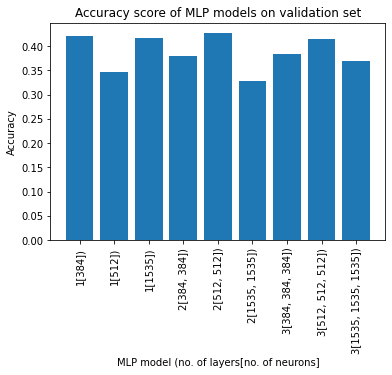

In [37]:
ls_layer_v_neuron = [f'{len(layers_and_neurons[i])}{layers_and_neurons[i]})' for i in range(len(layers_and_neurons))]

plt.bar(ls_layer_v_neuron, accuracies)
plt.title("Accuracy score of MLP models on validation set")
plt.xlabel('MLP model (no. of layers[no. of neurons]')
plt.xticks(rotation = 90)
plt.ylabel('Accuracy')
plt.show()

Get the best model

In [41]:
max_index = accuracies.index(max(accuracies))
best_mlp = ls_mlps[max_index]
best_layer = list(layers_and_neurons[max_index])
print(f"Best MLP model w/ {len(best_layer)} hidden layers and {best_layer[0]} neurons each")
print("Accuracy:", accuracies[max_index])

Best MLP model w/ 2 hidden layers and 512 neurons each
Accuracy: 0.4270833333333333


Evaluate accuracy

Text(33.0, 0.5, 'Truth')

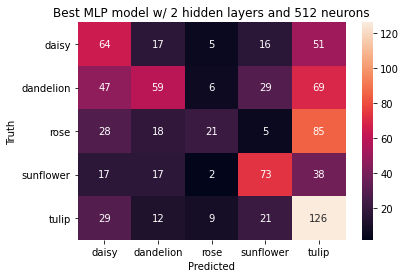

In [42]:
# Predict labels for confusion matrix
y_pred = mlp.predict(x_test_reshaped)
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

sn.heatmap(cm_array_df, annot=True, fmt='d')
plt.title(f"Best MLP model w/ {len(best_layer)} hidden layers and {best_layer[0]} neurons")
plt.xlabel('Predicted')
plt.ylabel('Truth') 

Examples of correctly classified flowers

daisy
sunflower
tulip
tulip
daisy
dandelion
dandelion


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

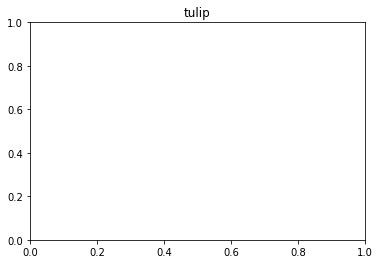

In [95]:
images_to_show = 3

# Find the indexes of the correctly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower == y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(y_test[i])
    ax1.imshow(cv2.cvtColor(x_image[i], cv2.COLOR_BGR2RGB))
    plt.show()

Examples of wrongly classified flowers

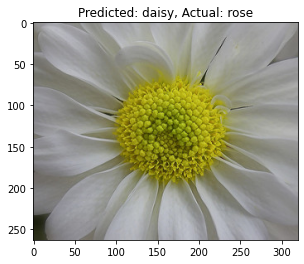

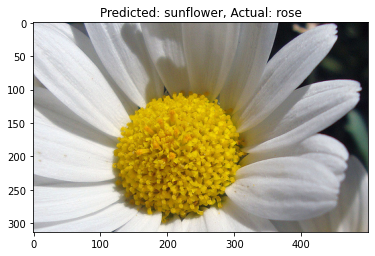

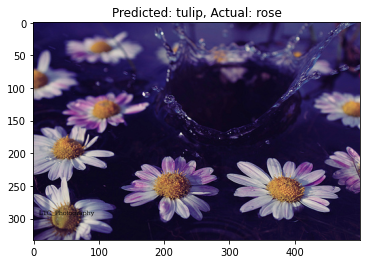

In [46]:
images_to_show = 3

# Find the indexes of the wrongly classified flowers
wrong_indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower != y_test[i]:
            wrong_indexes.append(i)
            # Break out of loops if already found enough samples
            if len(wrong_indexes) >= images_to_show:
                break

for i in wrong_indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')
    ax1.imshow(cv2.cvtColor(x_image[i], cv2.COLOR_BGR2RGB))
    plt.show()